In [2]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch
from torchtext import data
import random
import torch.nn as nn
import torch.optim as optim
import time
import spacy
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

stemmer = PorterStemmer()
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [5]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Negative":
            y.values[i]=0.0
        elif y[i]=="Positive":
            y.values[i]=1.0
        else:
            y.values[i]=2.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

In [6]:
with open("Tech_news.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")

print("Number of Examples : ",len(X),"\n")
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n******************\n")
#print(X.groupby(['Target']).count())
X['Target']=target_arrange(X['Target'])
X=X.drop('Date',1)

L=[]
L.append((X['Target']==0.0).sum())
L.append((X['Target']==1.0).sum())
L.append((X['Target']==2.0).sum())

print("Negative Examples : ",(X['Target']==0.0).sum())
print("Positive Examples : ",(X['Target']==1.0).sum())
print("Neutral Examples : ",(X['Target']==2.0).sum())

maximum=max(L)

Weights=[]

for i in L:
  Weights.append(maximum/i)
  
class_weights = torch.FloatTensor(Weights).to(device)
print("\n Weights = ",class_weights)


Number of Examples :  16887 

Number of Examples after removing duplicates:  16629 

Number of words before cleaning :  626338
Number of words after cleaning :  421010

******************

Negative Examples :  2078
Positive Examples :  6294
Neutral Examples :  8257

 Weights =  tensor([3.9735, 1.3119, 1.0000], device='cuda:0')


In [7]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])
print(X['Article'])


0        progress second quarter revenu exce guidanc in...
1        acuiti brand declar quarterli dividend atlanta...
2        mercuri system receiv contract award base new ...
3         share factset soar today earn came better expect
4        stifel say inseego leader inseego corp nasdaq ...
                               ...                        
16624    itali antitrust watchdog initi probe appl goog...
16625    godaddi share rose august domain name onlin bu...
16626    deliveri hero issu new share authoris capit de...
16627    sharehold alert pomerantz law firm investig cl...
16628    gener trend revers fed inflat polici faang sto...
Name: Article, Length: 16629, dtype: object


In [8]:
X.to_csv (r'Tech.csv', index = False, header=True)

In [9]:
torch.manual_seed(1234)
torch.backends.cudnn.deterministic = True

batch=256
#TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
TEXT = data.Field(batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.long,batch_first=True)

fields = [('text',TEXT),('label', LABEL)]
Train_Data=data.TabularDataset(path = 'Tech.csv',format = 'csv',fields = fields,skip_header = True)

X_train, X_test = Train_Data.split(split_ratio=0.75, random_state = random.seed(1234))
X_train, X_val = X_train.split(split_ratio=0.8, random_state = random.seed(1234))

TEXT.build_vocab(X_train, min_freq=2)  
LABEL.build_vocab(X_train)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  
train_it, val_it, test_it = data.BucketIterator.splits((X_train, X_val, X_test),sort_key = lambda x: len(x.text),
    sort_within_batch=True,batch_size = batch,device = device)  



Size of TEXT vocabulary: 8004
Size of LABEL vocabulary: 3
[('stock', 4344), ('earn', 3821), ('inc', 2829), ('result', 2518), ('compani', 2453), ('announc', 2359), ('report', 2064), ('quarter', 2033), ('busi', 2002), ('new', 1602)]


In [10]:
def find_accuracy(preds, y):
   
    temp = torch.log_softmax(preds, dim = 1)
    _, y_pred = torch.max(temp, dim = 1) 
    valid = (y_pred == y).float() 
    accur = valid.sum() / len(valid)
    return accur,y_pred,y

def Loss_Optimizer (model,valueLR):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=valueLR)
    return optimizer,criterion

In [11]:
def train(model,data,lr,optimizer,criterion):
        
    #optimizer,criterion=Loss_Optimizer (model,lr)
    #criterion = criterion.to(device)
    model.train()
    sumloss=0.0
    sumacc=0.0
    for i in data:
        text, text_lengths = i.text   
        optimizer.zero_grad()
        pred = model(text, text_lengths).squeeze(0)       
        loss = criterion(pred, i.label)
        acc,dummy,dummy2 = find_accuracy(pred, i.label)
        loss.backward()
        optimizer.step()
        sumloss += loss.item()
        sumacc += acc.item()
          
    return sumloss / len(data), sumacc / len(data)

In [12]:
def test(model, data, criterion):
    y_pred_list = []
    y_true_list = []
    sumloss = 0
    sumacc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i in data:
            text, text_lengths = i.text
            
            pred = model(text, text_lengths).squeeze(0)
           
            loss = criterion(pred, i.label)
            
            acc,y_pred_tags,y_true = find_accuracy(pred, i.label)

            sumloss += loss.item()
            sumacc += acc.item()
            y_pred_list.append(y_pred_tags.cpu().numpy())
            y_true_list.append(y_true.cpu().numpy())
        
    return sumloss / len(data), sumacc / len(data),y_pred_list,y_true_list

In [13]:
def process_test(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc,dummy,dummy2 = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            max=valid_acc
            torch.save(model.state_dict(), best_model)
        elif valid_acc > max:
            max = valid_acc
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc,y_pred_list,y_true_list = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_true_list = [a.squeeze().tolist() for a in y_true_list]
    
    yp = [item for sublist in y_pred_list for item in sublist]
    yt = [item for sublist in y_true_list for item in sublist]
    
    cnf_matrix = confusion_matrix(yt, yp,labels=[0, 1, 2])
    np.set_printoptions(precision=2)

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2],
                      title='Confusion matrix, with normalization')
    

In [14]:
def process_test2(model,numEpochs,data_tr,data_val,data_test,lr,loss_file,acc_file,best_model):

    optimizer,criterion=Loss_Optimizer (model,lr)
    criterion = criterion.to(device)
    start_time = time.time()
    fileout=open(loss_file,"w")
    fileout2=open(acc_file,"w")
    
    for i in range(numEpochs):
 
        train_loss, train_acc = train(model, data_tr, lr,optimizer,criterion)
        valid_loss, valid_acc = test(model, data_val, criterion)
        fileout.write(str(valid_loss)+"\n")
        fileout2.write(str(valid_acc)+"\n")
        if i==0:
            minloss=valid_loss
            torch.save(model.state_dict(), best_model)
        elif valid_loss < minloss:
            minloss = valid_loss
            torch.save(model.state_dict(), best_model)

        if (i+1)%5==0:
          print("Epoch : ",i+1," Train Loss : ",train_loss,"  Train Acc : ",train_acc,"  Valid Loss : ",valid_loss, " Val Acc : ",valid_acc)
    
    end_time = time.time()
    timeHelp=(end_time-start_time)/60.0
    print("\nTime needed for Training : ",timeHelp)

    fileout.close()
    fileout2.close()  
    
   
    model.load_state_dict(torch.load(best_model))
    
    test_loss, test_acc = test(model, data_test, criterion)
    print("\nLoss in Testset : ",test_loss,"  Accuracy in Testset : ",test_acc,"\n")

In [15]:
print("GPU Model   ",torch.cuda.get_device_name(0))

GPU Model    Tesla T4


In [16]:
class myLSTM(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.LSTM(embed_d,hid_d,batch_first=True,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text, text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,(rnn_hid,rnn_cell) = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((rnn_hid[-2,:,:], rnn_hid[-1,:,:]), dim=1))
        return self.fc(hidden)

In [17]:
class myGRU(nn.Module):
    def __init__(self, voc, embed_d, hid_d, out_d,dropout):
        
        super().__init__()
        
        self.embedding = nn.Embedding(voc, embed_d)
        self.rnn = nn.GRU(embed_d,hid_d,num_layers=2,bidirectional=True,dropout=dropout)
        self.fc = nn.Linear(hid_d * 2, out_d)
        self.dropout = nn.Dropout(dropout)
    def forward(self, input_text,text_lengths):
                
        embedded = self.dropout(self.embedding(input_text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        rnn_out,hidden = self.rnn(packed_embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

In [18]:
myInput = len(TEXT.vocab)
myEmbed = 300
myHid = 256
myOut = 3
dropout = 0.4

new_model2 = myLSTM(myInput, myEmbed, myHid, myOut,dropout)
new_model2.to(torch.device(device))
new_model3 = myGRU(myInput, myEmbed, myHid, myOut,dropout)
new_model3.to(torch.device(device))

print(new_model2)
print(new_model3)
#torch.save(new_model2.state_dict(), 'model_LSTM_1.pt')

myLSTM(
  (embedding): Embedding(8004, 300)
  (rnn): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
myGRU(
  (embedding): Embedding(8004, 300)
  (rnn): GRU(300, 256, num_layers=2, dropout=0.4, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


Epoch :  5  Train Loss :  0.30580070765259176   Train Acc :  0.8785032064486773   Valid Loss :  0.4682141527533531  Val Acc :  0.8213157951831818
Epoch :  10  Train Loss :  0.11489612912872615   Train Acc :  0.9586338141025641   Valid Loss :  0.672948132455349  Val Acc :  0.8315912842750549
Epoch :  15  Train Loss :  0.058834223536392435   Train Acc :  0.9807692307692307   Valid Loss :  0.8234329104423523  Val Acc :  0.822997534275055
Epoch :  20  Train Loss :  0.040935074674705856   Train Acc :  0.9859775641025641   Valid Loss :  0.940739169716835  Val Acc :  0.8232524693012238
Epoch :  25  Train Loss :  0.032905854298195876   Train Acc :  0.9886818910256411   Valid Loss :  0.9705119997262954  Val Acc :  0.8330180943012238
Epoch :  30  Train Loss :  0.01912378636673869   Train Acc :  0.992988782051282   Valid Loss :  1.1324013978242875  Val Acc :  0.8259868443012237

Time needed for Training :  0.8598657846450806

Loss in Testset :  1.099610150745588   Accuracy in Testset :  0.8405330

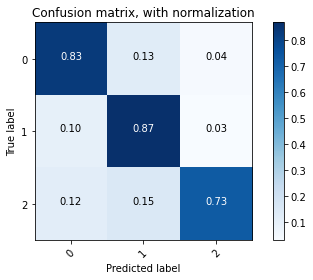

In [19]:
process_test(new_model2,30,train_it,val_it,test_it,0.001,"lstm1_loss.txt","lstm1_acc.txt","best_LSTM_1_model.pt")

Epoch :  5  Train Loss :  0.32645063379254097   Train Acc :  0.8686802891584543   Valid Loss :  0.4782839708030224  Val Acc :  0.8118051052093506
Epoch :  10  Train Loss :  0.14467928118896312   Train Acc :  0.9426081730769231   Valid Loss :  0.6496037840843201  Val Acc :  0.8176480293273926
Epoch :  15  Train Loss :  0.07433939312632458   Train Acc :  0.9724559294871795   Valid Loss :  0.8098353162407875  Val Acc :  0.8322532951831818
Epoch :  20  Train Loss :  0.03606086837587496   Train Acc :  0.9863758026025234   Valid Loss :  0.9430564343929291  Val Acc :  0.8314720451831817
Epoch :  25  Train Loss :  0.031185871076722365   Train Acc :  0.989082532051282   Valid Loss :  0.9940624356269836  Val Acc :  0.8296381592750549
Epoch :  30  Train Loss :  0.030409486611927442   Train Acc :  0.9884815705128205   Valid Loss :  1.0371207505464555  Val Acc :  0.8282113552093506

Time needed for Training :  0.7564652919769287

Loss in Testset :  0.7914167150088093   Accuracy in Testset :  0.8347

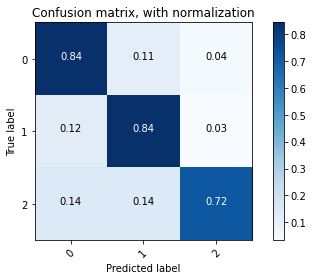

In [20]:
process_test(new_model3,30,train_it,val_it,test_it,0.001,"gru1_loss.txt","gru1_acc.txt","best_gru_1_model.pt")